# MICROSCOPE Session 380

In [1]:
%matplotlib notebook
from matplotlib import pyplot as plt
import pyfftw
import fftwisdom
import numpy as np
from pyfftw.interfaces.numpy_fft import fft, ifft
from microspy import fileload, model, cmsread, regression, rdbin
from microspy import preprocessing
from mecm import psd
from mecm import mecm
from plottools import presets
pyfftw.interfaces.cache.enable()

### 1.Load N2 data

In [2]:
# Root path
root_path = '/Users/qbaghi/Documents/MICROSCOPE/data/session_380/N1N2/'
# Session name
session_name = 'Session_380_EPR_V3DFIS2_01_SUREF'
# Data level
data_level = 'N2a_01_L_SCA_G_0050'
# Sensor unit
su = 'SUREF'

file_path = root_path + session_name + '/' + data_level + '/' + su + '/'

# Load data
acc_d, acc_c, t, mask = fileload.load_acceleration_modes(
    file_path, axes=np.array(['X', 'Y', 'Z']), voie='sca', prefix='Acc')

### 2. Preprocessing

In [3]:
# Differential mode
n_data = acc_d.shape[0]
fs = 4.0
fep = 3.1114e-3
mask_d = np.ones(n_data)
mask_d[acc_d[:, 0] == 0] = 0
acc_d_m = (acc_d - np.mean(acc_d[mask_d == 1], axis=0))
acc_d_m = acc_d_m * np.array([mask_d]).T

mask_c = np.ones(n_data)
mask_c[acc_c[:, 0] == 0] = 0
acc_c_m = (acc_c - np.mean(acc_c[mask_c == 1, :], axis=0))
acc_c_m = acc_c_m * np.array([mask_c]).T

# # Load mask
# mask = rdbin.read(file_path + 'MaskDifN2Xscaa.bin')
# mask_d = mask._values
t = np.arange(0, n_data) / fs

### 3. Detection of glitches using sigma-clipping

In [4]:
# Sigma-clipping
mask_clip = preprocessing.sigma_clip(acc_c_m[:, 0], k=5, n_it=3, margin=5,
                                     mask_init=mask_c)
print("Discard " + str(100 * (n_data - np.sum(mask_clip)) / n_data) + " percent of data.")

Discard 2.296693501367897 percent of data.


In [5]:
f = np.fft.fftfreq(n_data) * fs
wd = np.hanning(n_data)


#### Mask periodogram

<IPython.core.display.Javascript object>


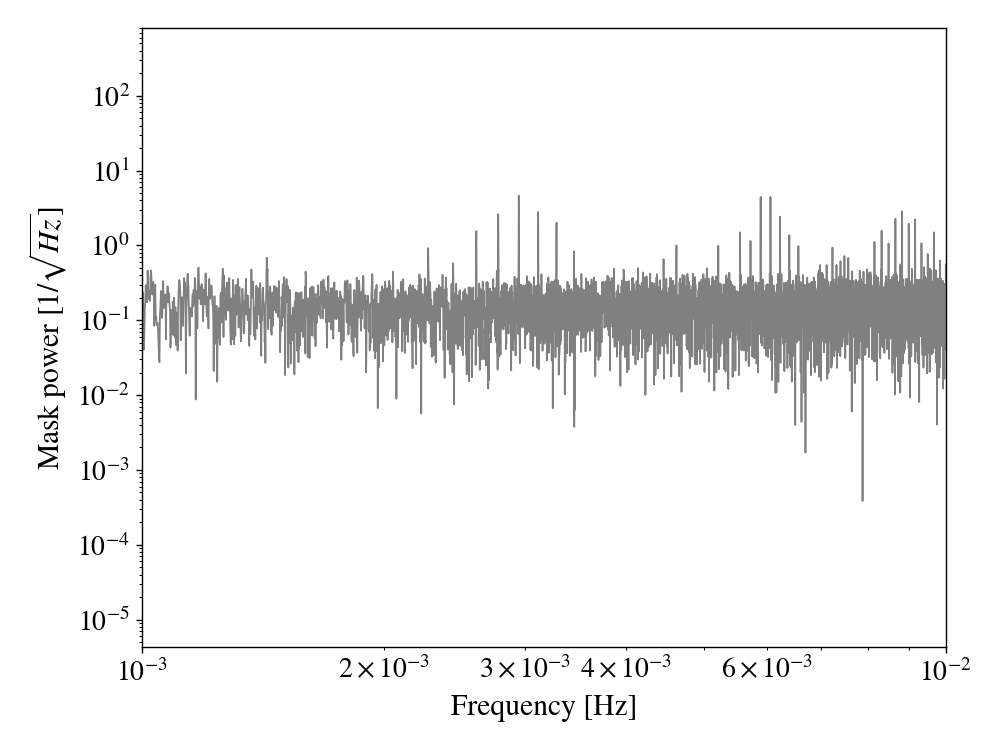

In [6]:
pmask = model.periodogram(mask_clip, wd)
idpos = np.where(f > 0)[0]

presets.plotconfig(ctype='time', lbsize=16, lgsize=14)
fig1, ax1 = plt.subplots(nrows=1, sharex=True, sharey=True)
ax1.loglog(f[idpos], np.sqrt(pmask[idpos] / fs), color='gray', linewidth=1)
# ax1.legend(loc='upper left')
ax1.set_xlabel("Frequency [Hz]")
ax1.set_ylabel(r"Mask power [$1/\sqrt{Hz}$]")
ax1.set_xlim([1e-3, 1e-2])
plt.show()

### 4. Build physical model in the time domain

In [ ]:
# t1, gx, mask = cmsread.read_cmsm(file_path + 'Acc_gravite1.bin')
pm = model.PhysicsModel(file_path, su)
pm.loadgradients(actens=False, fileformat='bin')
# t1, gx, mask = cmsread.rdData(file_path + 'Acc_gravite1.bin')
full_mat = np.column_stack([0.5 * pm.g, pm.sxx, pm.sxz, np.ones(n_data)])
# Add polynomial trend
deg = 0
polys = np.column_stack([(t * fs) ** i for i in range(deg + 1)])
full_mat = np.hstack([full_mat, polys])  # * np.array([mask_d]).T

### 5. Analysis of a small segment lasting 20 orbits starting at the 24th orbit

In [ ]:
# We work with a subset of data
ns = 2**19
# Starting at 24th orbit
forb = 1.7e-4
n_start = np.int(24 / forb * fs)
# Corresponding Indices
inds = np.arange(n_start, n_start + ns)

# Restricted sigma-clipping mask
mask = mask_clip[inds]
# Apodization windowing
w = np.hanning(ns)
# Re-scale the data to avoid numerical issues
scale = 1e-9
# Data masked with sigma-clipping
y = acc_d[inds, 0] / scale

# Data minimally masked
y0 = acc_d[inds, 0] * mask_d[inds] / scale

# Restricted model
a_mat = full_mat[inds, :]

# PSD estimation
psd_cls = psd.PSDSpline(ns, fs, n_knots=30, d=3, fmin=None, fmax=None)
# psd_cls.estimate((y0 - np.mean(y0)) * mask_d[inds], wind=w*mask_d[inds])
# s_n = psd_cls.calculate(ns)
# s_2n = psd_cls.calculate(2 * ns)

In [ ]:
# Plot periodogram on restricted segment of 44 orbits
# --------------------------------------------------------------------------
f = np.fft.fftfreq(ns) * fs
idpos = np.where(f > 0)[0]
py0 = model.periodogram((y0 - np.mean(y0)) * mask_d[inds], w*mask_d[inds])
# fig1, ax1 = plt.subplots(nrows=1, sharex=True, sharey=True)
# ax1.loglog(f[idpos], np.sqrt(py0[idpos] / fs), color='black',
#            label='Analysed data')
# ax1.loglog(f[idpos], np.sqrt(s_n[idpos] / fs), color='red',
#            label='Estimated PSD')
# ax1.legend(loc='upper left')
# ax1.set_xlabel("Frequency [Hz]")
# ax1.set_ylabel("Acceleration [m/s2/sqrt{Hz}]")
# plt.show()

### 9. Run MECM

In [ ]:
# MECM parameters
# Convergence criterium
tol_cg = 1e-4
# Maximum autocovariance lag for sparse approximation of the covariance
p = 60
# Maximum number of iterations of the PCG
nit_cg = 1000
# PCG algorithm to use
pcg_algo = 'scipy'
# Parameter estimation convergence criterium
eps = 1e-3
# Number of random draws for conditional periodogram estimation
nd = 1


# a0_est, a0_cov, a0_vect, y_rec, p_cond_mean, psd_cls, success = mecm.maxlike(
#     y, mask, a_matrix, n_it_max=15, eps=1e-3, p=p, nd=10, n_est=100,
#     nit_cg=nit_cg, tol_cg=tol_cg, compute_cov=True, verbose=True,
#     pcg_algo='scipy', psd_cls=None)

# Intantiate ECM class
ecm = mecm.MECM(y, mask, a_mat, psd_cls, eps=eps, p=p,
                nd=nd, nit_cg=nit_cg, tol_cg=tol_cg, pcg_algo=pcg_algo, mask0=mask_d[inds])

In [ ]:
# Compute first residuals
p_res = model.periodogram(ecm.res, ecm.wd*ecm.mask0)
# Verify that initialization is well done
fig1, ax1 = plt.subplots(nrows=1, sharex=True, sharey=True)
ax1.loglog(f[idpos], np.sqrt(py0[idpos] / fs), color='black',
           label='Analysed data')
ax1.loglog(f[idpos], np.sqrt(p_res[idpos] / fs), color='gray', label='Residuals')
ax1.loglog(f[idpos], np.sqrt(ecm.s_n[idpos] / fs), color='red', label='Estimated PSD')
ax1.legend(loc='upper left')
ax1.set_xlabel("Frequency [Hz]")
ax1.set_ylabel(r"Acceleration [$\rm ms^{-2}{Hz}^{-1/2}$]")
plt.show()

In [ ]:
# Run 1 E-step
ecm.e_step()

In [ ]:
len(ecm.p_cond_mean)

In [ ]:
# Run 1 M-step
ecm.cm1_step()  # PSD estimation
ecm.cm2_step()  # Regression parameters

### 10. Analysing the recontructed data

In [ ]:
# Periodogram of reconstructed data
pyrec = model.periodogram(ecm.y_rec - ecm.y_rec.mean(), ecm.wd)
# psig = model.periodogram(ecm.signal, ecm.wd)
# Compare it with the initial, non-clipped data segment
py0 = model.periodogram((y0 - np.mean(y0)) * mask_d[inds], w*mask_d[inds])
iep = np.where((f>1e-5) & (f<4e-1))
# Plot them
fig1, ax1 = plt.subplots(nrows=1, sharex=True, sharey=True)
ax1.loglog(f[iep], np.sqrt(py0[iep] / fs) * scale, color='gray',
           label='Initial data')
ax1.loglog(f[iep], np.sqrt(pyrec[iep] / fs) * scale, color='blue',
           label='Imputed residuals')
# ax1.loglog(f[iep], np.sqrt(pyrec[iep] / fs) * scale, color='blue', linestyle='dashed',
#            label='Estimated signal')
ax1.loglog(f[iep], np.sqrt(ecm.s_n[iep] / fs) * scale, color='red', label='Estimated PSD')
ax1.legend(loc='upper left')
ax1.set_xlabel(r"Frequency [Hz]")
ax1.set_ylabel(r"Acceleration PSD [$\mathrm{ms^{-2}{Hz}^{-1/2}}$]")
# ax1.set_xlim([3e-3, 3.2e-3])

# Restrict to frequencies around f_EP
iep = np.where((f>2e-3) & (f<4e-3))
# Plot them
fig2, ax2 = plt.subplots(nrows=1, sharex=True, sharey=True)
ax2.plot(f[iep], np.sqrt(py0[iep] / fs) * scale, color='gray',
           label='Initial data')
ax2.plot(f[iep], np.sqrt(pyrec[iep] / fs) * scale, color='blue',
           label='Imputed residuals')
ax2.plot(f[iep], np.sqrt(ecm.s_n[iep] / fs) * scale, color='red', label='Estimated PSD')
ax2.legend(loc='upper left')
ax2.set_xlabel(r"Frequency [Hz]")
ax2.set_ylabel(r"Acceleration PSD [$\mathrm{ms^{-2}{Hz}^{-1/2}}$]")
# ax1.set_xlim([3e-3, 3.2e-3])
plt.show()

plt.show()


### 11. Full M-ECM run

In [ ]:
# Run M-ECM iterations alternating betweeb E-steps and M-steps
n_it_max = 15
[ecm.ecm_step(verbose=True) for i in range(n_it_max)]

In [ ]:
# Periodogram of reconstructed data
pyrec = model.periodogram(ecm.y_rec - ecm.y_rec.mean(), ecm.wd)
psig = model.periodogram(ecm.signal, ecm.wd)
iep = np.where((f>1e-5) & (f<4e-1))
# Plot them
fig1, ax1 = plt.subplots(nrows=1, sharex=True, sharey=True)
ax1.loglog(f[iep], np.sqrt(py0[iep] / fs) * scale, color='gray', linewidth=1,
           label='Initial data')
ax1.loglog(f[iep], np.sqrt(pyrec[iep] / fs) * scale, color='blue', linewidth=1,
           label='Imputed residuals')
ax1.loglog(f[iep], np.sqrt(psig[iep] / fs) * scale, color='green', linestyle='dashed', linewidth=1,
           label='Estimated signal')
ax1.loglog(f[iep], np.sqrt(ecm.s_n[iep] / fs) * scale, color='red', label='Estimated PSD')
ax1.legend(loc='upper left')
ax1.set_xlabel(r"Frequency [Hz]")
ax1.set_ylabel(r"Acceleration PSD [$\mathrm{ms^{-2}{Hz}^{-1/2}}$]")
# Restrict to frequencies around f_EP
iep = np.where((f>2e-3) & (f<4e-3))
# Plot them
fig2, ax2 = plt.subplots(nrows=1, sharex=True, sharey=True)
ax2.plot(f[iep], np.sqrt(py0[iep] / fs) * scale, color='gray', linewidth=1,
           label='Initial data')
ax2.plot(f[iep], np.sqrt(pyrec[iep] / fs) * scale, color='blue', linewidth=1,
           label='Imputed residuals')
ax2.plot(f[iep], np.sqrt(psig[iep] / fs) * scale, color='green', linestyle='dashed', linewidth=1,
           label='Estimated signal')
ax2.plot(f[iep], np.sqrt(ecm.s_n[iep] / fs) * scale, color='red',
           label='Estimated PSD')
ax2.legend(loc='upper left')
ax2.set_xlabel(r"Frequency [Hz]")
ax2.set_ylabel(r"Acceleration PSD [$\mathrm{ms^{-2}{Hz}^{-1/2}}$]")
# ax1.set_xlim([3e-3, 3.2e-3])
plt.show()

plt.show()